In [1]:
conda activate bns


Note: you may need to restart the kernel to use updated packages.


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.stats import lognorm
import os

from BNS_JT import cpm, variable
from BNS_JT.trans import get_arcs_length, get_all_paths_and_times
from BNS_JT.cpm import variable_elim, mcs_product, single_sample, get_sample_order


In [4]:
np.set_printoptions(precision=3)
HOME = os.getcwd()

# Toy example

## First, add hazard nodes.

In [9]:
cpms = {}
varbs = {}

low = 0
high = 1
p_low = 0.95
varbs['haz'] = variable.Variable(name='haz', B = [[1,0],[0,1]], values=['low', 'high'])
C = np.array([[low, high]]).T
p = np.array([p_low, 1-p_low])
cpms['haz'] = cpm.Cpm( variables = [varbs['haz']], no_child = 1, C = C, p = p )
print(varbs['haz'])
print(cpms['haz'])

"Variable(name=haz, B=[[1 0]\n [0 1]], values=['low', 'high'])"
Cpm(variables=['haz'], no_child=1, C=[[0]
 [1]], p=[[0.95]
 [0.05]]


## Now network.

This is a reduced version of Sioux Falls benchmark network. <br>
Scales, epicentre location and road types are arbitrary.

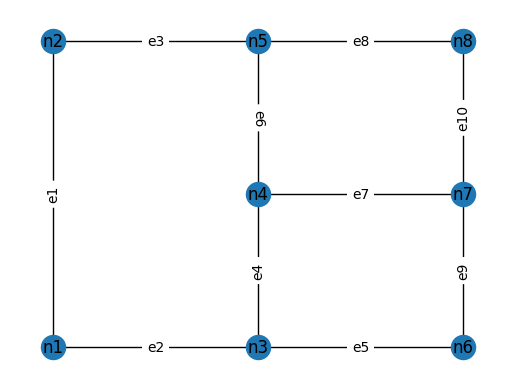

In [11]:
node_coords = {'n1': (0, 0),
               'n2': (0, 2),
               'n3': (2, 0),
               'n4': (2, 1),
               'n5': (2, 2),
               'n6': (4, 0),
               'n7': (4, 1),
               'n8': (4, 2)} # km

arcs = {'e1': ['n1', 'n2'],
        'e2': ['n1', 'n3'],
        'e3': ['n2', 'n5'],
        'e4': ['n3', 'n4'],
        'e5': ['n3', 'n6'],
        'e6': ['n4', 'n5'],
        'e7': ['n4', 'n7'],
        'e8': ['n5', 'n8'],
        'e9': ['n6', 'n7'],
        'e10': ['n7', 'n8']}

# Fragility curves -- From HAZUS-EQ model (roads are regarded as disconnected when being extensively or completely damaged)

frag = {'major': {'med': 60.0, 'std': 0.7},
        'urban' : {'med': 24.0, 'std': 0.7},
        'bridge': {'med': 1.1, 'std': 3.9}}

arcs_type = {'e1': 'major',
             'e2': 'major',
             'e3': 'bridge',
             'e4': 'urban',
             'e5': 'major',
             'e6': 'urban',
             'e7': 'urban',
             'e8': 'bridge',
             'e9': 'urban',
             'e10': 'urban'}

arcs_avg_kmh = {'e1': 50,
                'e2': 50,
                'e3': 50,
                'e4': 30,
                'e5': 50,
                'e6': 30,
                'e7': 30,
                'e8': 50,
                'e9': 30,
                'e10': 30}

var_ODs = {'od1': ('n1', 'n4'),
           'od2': ('n1', 'n6'),
           'od3': ('n1', 'n8')}

nODs = len(var_ODs)

# Arcs' states index compatible with variable B index, and C
arc_surv = 1 - 1
arc_fail = 2 - 1
arc_either = 3 - 1

arc_lens_km = get_arcs_length(arcs, node_coords)

#arcTimes_h = arcLens_km ./ arcs_Vavg_kmh
arc_times_h = {k: v/arcs_avg_kmh[k] for k, v in arc_lens_km.items()}

# create a graph
G = nx.Graph()
for k, x in arcs.items():
    G.add_edge(x[0], x[1], time=arc_times_h[k], label=k)

for k, v in node_coords.items():
    G.add_node(k, pos=v)

path_time = get_all_paths_and_times(var_ODs.values(), G, key='time')

# plot graph
pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label')

fig = plt.figure()
ax = fig.add_subplot()
nx.draw(G, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
fig.savefig( os.path.join(HOME, 'graph_rsf.png'), dpi=200)

# Arcs (components): P(X_i | GM = GM_ob ), i = 1 .. N (= nArc)

B = np.array([[1, 0], [0, 1], [1, 1]])
C = np.array([[arc_surv, low], [arc_fail, low],
              [arc_surv, high], [arc_fail, high]])


In [ ]:
####### 150723: Start from below. A function to get "path_time_idx"? Another mission is to have the hazard nodes.

for k in arcs.keys():
    varbs[k] = variable.Variable(name=str(k), B=B, values=['Surv', 'Fail'])

    _type = arcs_type[k]
    prob = [lognorm.cdf(GM_obs[k], frag[_type]['std'], scale=frag[_type]['med']),
           lognorm.cdf(GM_obs[k]*1.5, frag[_type]['std'], scale=frag[_type]['med'])]
    
    p = np.array([1-prob[0], prob[0], 1-prob[1], prob[1]])
    cpms[k] = cpm.Cpm(variables = [vars_arc[k], var_h],
                          no_child = 1,
                          C = C,
                          p = p)

The script below is from *Trans/tests/test_Transport.py*.

In [45]:
node_coords = {'n1': (-2, 3),
               'n2': (-2, -3),
               'n3': (2, -2),
               'n4': (1, 1),
               'n5': (0, 0)}

arcs = {'e1': ['n1', 'n2'],
	'e2': ['n1', 'n5'],
	'e3': ['n2', 'n5'],
	'e4': ['n3', 'n4'],
	'e5': ['n3', 'n5'],
	'e6': ['n4', 'n5']}

# Fragility curves -- From HAZUS-EQ model (roads are regarded as disconnected when being extensively or completely damaged)

frag = {'major': {'med': 60.0, 'std': 0.7},
        'urban' : {'med': 24.0, 'std': 0.7},
        'bridge': {'med': 1.1, 'std': 3.9}}

arcs_type = {'e1': 'major',
             'e2': 'major',
             'e3': 'major',
             'e4': 'urban',
             'e5': 'bridge',
             'e6': 'bridge'}

arcs_avg_kmh = {'e1': 40,
                'e2': 40,
                'e3': 40,
                'e4': 30,
                'e5': 30,
                'e6': 20}

var_ODs = {'od1': ('n5', 'n1'),
           'od2': ('n5', 'n2'),
           'od3': ('n5', 'n3'),
           'od4': ('n5', 'n4')}

nODs = len(var_ODs)

# For the moment, we assume that ground motions are observed. Later, hazard nodes will be added.
GM_obs = {'e1': 30.0,
          'e2': 20.0,
          'e3': 10.0,
          'e4': 2.0,
          'e5': 0.9,
          'e6': 0.6}

# Arcs' states index compatible with variable B index, and C
arc_surv = 1 - 1
arc_fail = 2 - 1
arc_either = 3 - 1

arc_lens_km = get_arcs_length(arcs, node_coords)

#arcTimes_h = arcLens_km ./ arcs_Vavg_kmh
arc_times_h = {k: v/arcs_avg_kmh[k] for k, v in arc_lens_km.items()}

# create a graph
G = nx.Graph()
for k, x in arcs.items():
    G.add_edge(x[0], x[1], time=arc_times_h[k], label=k)

for k, v in node_coords.items():
    G.add_node(k, pos=v)

path_time = get_all_paths_and_times(var_ODs.values(), G, key='time')

# plot graph
pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label')

fig = plt.figure()
ax = fig.add_subplot()
nx.draw(G, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
fig.savefig( os.path.join(HOME, 'graph.png'), dpi=200)

# Arcs (components): P(X_i | GM = GM_ob ), i = 1 .. N (= nArc)

B = np.array([[1, 0], [0, 1], [1, 1]])
C = np.array([[arc_surv, low], [arc_fail, low],
              [arc_surv, high], [arc_fail, high]])

for k in arcs.keys():
    varbs[k] = variable.Variable(name=str(k), B=B, values=['Surv', 'Fail'])

    _type = arcs_type[k]
    prob = [lognorm.cdf(GM_obs[k], frag[_type]['std'], scale=frag[_type]['med']),
           lognorm.cdf(GM_obs[k]*1.5, frag[_type]['std'], scale=frag[_type]['med'])]
    
    p = np.array([1-prob[0], prob[0], 1-prob[1], prob[1]])
    cpms[k] = cpm.Cpm(variables = [vars_arc[k], var_h],
                          no_child = 1,
                          C = C,
                          p = p)

# Travel times (systems): P(OD_j | X1, ... Xn) j = 1 ... nOD
B_ = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
varbs['od1'] = variable.Variable(name='od1', B=B_,
        values=[0.0901, 0.2401, np.inf])

_variables = [vars_arc[k] for k in ['od1', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6']]
c7 = np.array([
[1,3,1,3,3,3,3],
[2,1,2,1,3,3,3],
[3,1,2,2,3,3,3],
[3,2,2,3,3,3,3]]) - 1
cpms['od1'] = cpm.Cpm(variables= _variables,
                       no_child = 1,
                       C = c7,
                       p = [1, 1, 1, 1],
                       )

In [46]:
print(cpms)
print(varbs)

{'haz': Cpm(variables=['haz'], no_child=1, C=[[0]
 [1]], p=[[0.95]
 [0.05]], 'e1': Cpm(variables=['e1', 'haz'], no_child=1, C=[[0 0]
 [1 0]
 [0 1]
 [1 1]], p=[[0.839]
 [0.161]
 [0.659]
 [0.341]], 'e2': Cpm(variables=['e2', 'haz'], no_child=1, C=[[0 0]
 [1 0]
 [0 1]
 [1 1]], p=[[0.942]
 [0.058]
 [0.839]
 [0.161]], 'e3': Cpm(variables=['e3', 'haz'], no_child=1, C=[[0 0]
 [1 0]
 [0 1]
 [1 1]], p=[[0.995]
 [0.005]
 [0.976]
 [0.024]], 'e4': Cpm(variables=['e4', 'haz'], no_child=1, C=[[0 0]
 [1 0]
 [0 1]
 [1 1]], p=[[9.998e-01]
 [1.927e-04]
 [9.985e-01]
 [1.486e-03]], 'e5': Cpm(variables=['e5', 'haz'], no_child=1, C=[[0 0]
 [1 0]
 [0 1]
 [1 1]], p=[[0.521]
 [0.479]
 [0.479]
 [0.521]], 'e6': Cpm(variables=['e6', 'haz'], no_child=1, C=[[0 0]
 [1 0]
 [0 1]
 [1 1]], p=[[0.562]
 [0.438]
 [0.521]
 [0.479]], 'od1': Cpm(variables=['od1', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6'], no_child=1, C=[[0 2 0 2 2 2 2]
 [1 0 1 0 2 2 2]
 [2 0 1 1 2 2 2]
 [2 1 1 2 2 2 2]], p=[[1]
 [1]
 [1]
 [1]]}
{'haz': "Variable(n

# Inference

## Exact

In [72]:
#cpm_od1 = variable_elim( cpms, ['haz', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6'] )
# The function above does not work.

cpms_cp = list(cpms.values())
for i in ['haz'] + list(arcs.keys()):
    is_inscope = cpm.isinscope([varbs[i]], cpms_cp)
    cpm_sel = [y for x, y in zip( is_inscope, cpms_cp ) if x]
    cpm_mult = cpm.prod_cpms(cpm_sel)
    cpm_mult = cpm_mult.sum( [varbs[i]] )
    
    cpms_cp = [y for (x,y) in zip( is_inscope, cpms_cp ) if x == False]
    cpms_cp.insert(0, cpm_mult)

print('Probability of disruption: ' + str(cpms_cp[0].p[1][0] + cpms_cp[0].p[2][0] ) )
print('Probability of disconnection: ' + str(cpms_cp[0].p[2][0]) )

Probability of disruption: 0.06341019501428664
Probability of disconnection: 0.012026510475349292


## MCS product by conditioning

In [100]:
nSample = 10
var_mcs = ['haz']
elim_order = ['e1', 'e2', 'e3', 'e4', 'e5', 'e6'] # except 'haz' and 'od1'


cpm_h_mcs = mcs_product([cpms['haz']], nSample)
#print(cpm_h_mcs)

for c, p in zip( cpm_h_mcs.C, cpm_h_mcs.q ):
    cpms_c = condition( cpms, 'haz', c )
    
    for v in elim_order:
        is_inscope = cpm.isinscope([varbs[i]], cpms_cp)
        cpm_sel = [y for x, y in zip( is_inscope, cpms_cp ) if x]
        cpm_mult = cpm.prod_cpms(cpm_sel)
        cpm_mult = cpm_mult.sum( [varbs[i]] )

        cpms_cp = [y for (x,y) in zip( is_inscope, cpms_cp ) if x == False]
        cpms_cp.insert(0, cpm_mult)



[0 0]
[1 0]
[0 1]
[1 1]


In [90]:
for i, (j, M) in enumerate(zip(sample_order, [cpms['haz']])):
    print(i)

0


In [58]:
print(['haz'] + list(arcs.keys()))

['haz', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6']


[0 1 2 3 4 5 6 7 8 9]
